# Mini-Beispiel zu Conv-Op in PyTorch

In [22]:
import torch
import torch.nn as nn

# 1️⃣ Einfacher Input: 1 Batch, 1 Kanal, 3x3 Pixel
# (Batchgröße, Kanäle, Höhe, Breite)
x = torch.tensor([[
    [[1.0, 2.0, 0.0],
     [0.0, 1.0, 3.0],
     [1.0, 2.0, 2.0]]
]], dtype=torch.float32)

print("Input:")
print(x)

# 2️⃣ Definiere eine Conv2d-Schicht
# Parameter: (in_channels, out_channels, kernel_size, stride, padding)
conv = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=2, stride=1, bias=False)

# 3️⃣ Setze die Gewichte manuell, damit das Ergebnis nachvollziehbar ist
# Ein einfacher 2x2-Filter
#with torch.no_grad():
#    conv.weight[0] = torch.tensor([[[[1.0, 0.0],
#                                     [0.0, -1.0]]]])  # Form: (out_channels, in_channels, kH, kW)

print("\nKernel (Gewichte):")
print(conv.weight)

# 4️⃣ Wende die Convolution an
y = conv(x)

print("\nOutput nach Convolution:")
print(y)

# Es sollte rauskommen für y:
#  0 -1
# -2 -1

Input:
tensor([[[[1., 2., 0.],
          [0., 1., 3.],
          [1., 2., 2.]]]])

Kernel (Gewichte):
Parameter containing:
tensor([[[[-0.1720,  0.1054],
          [-0.4739, -0.2098]]],


        [[[ 0.3477,  0.4648],
          [-0.0717, -0.3365]]],


        [[[-0.0789,  0.0047],
          [-0.0758, -0.4682]]],


        [[[ 0.4590, -0.4987],
          [ 0.4456, -0.3091]]],


        [[[-0.2676, -0.4082],
          [-0.3022,  0.3575]]],


        [[[ 0.0060,  0.1436],
          [ 0.1188,  0.2098]]]], requires_grad=True)

Output nach Convolution:
tensor([[[[-0.1711, -1.4474],
          [-0.7883, -1.2234]],

         [[ 0.9408, -0.3858],
          [-0.2800,  0.9257]],

         [[-0.5376, -1.6381],
          [-1.0074, -1.1525]],

         [[-0.8476,  0.4363],
          [-0.6714, -0.7643]],

         [[-0.7266,  0.2351],
          [ 0.0046, -1.3817]],

         [[ 0.5031,  0.7604],
          [ 0.6821,  1.0942]]]], grad_fn=<ConvolutionBackward0>)


In [23]:
y.shape

torch.Size([1, 6, 2, 2])

In [9]:
1*-0.0551 + 2*0.3352 + 0*-0.2422 + 1*0.0486 # MAC = Multiply-and-Accumulate

0.6638999999999999

# Beispiel auf gezeichnetem Bild

/tmp/ipykernel_8549/3958642744.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(arr, mode="RGB")


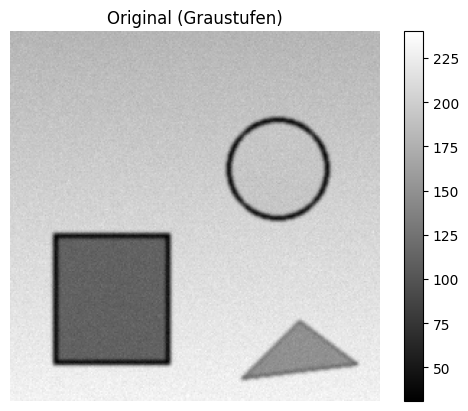

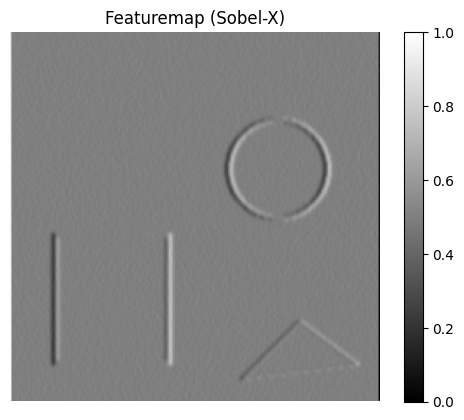

Input tensor shape (N, C, H, W): (1, 1, 256, 256)
Kernel shape (out, in, kH, kW): (1, 1, 3, 3)
Output tensor shape: (1, 1, 256, 256)
Featuremap stats: min=-3.6392, max=3.6314

Dateien gespeichert:
Original: synthetic_photo.png
Featuremap: feature_map_sobelx.png


In [9]:
# This script creates a simple "realistic" synthetic image, applies a Conv2d filter in PyTorch,
# and visualizes the resulting feature map. It also saves the images for download.

import torch
import torch.nn as nn
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import os

# 1) Create a simple synthetic "photo-like" image (RGB) with shapes & blur to mimic a real scene
w, h = 256, 256
img = Image.new("RGB", (w, h), (200, 205, 210))

draw = ImageDraw.Draw(img)
# Add a "sky" gradient-like overlay
for y in range(h):
    shade = int(180 + 50 * (y / h))
    for x in range(0, w, 4):
        draw.line([(x, y), (x+3, y)], fill=(shade, shade, shade))

# Add some objects
draw.rectangle([30, 140, 110, 230], outline=(20, 20, 20), width=3, fill=(60, 120, 200))
draw.ellipse([150, 60, 220, 130], outline=(10, 10, 10), width=3, fill=(230, 200, 60))
draw.polygon([(200, 200), (240, 230), (160, 240)], outline=(30, 30, 30), fill=(100, 180, 120))

# Add soft blur and slight noise to feel more "photo-like"
img = img.filter(ImageFilter.GaussianBlur(radius=1.2))
noise = (np.random.randn(h, w, 3) * 6).astype(np.int16)
arr = np.clip(np.array(img, dtype=np.int16) + noise, 0, 255).astype(np.uint8)
img = Image.fromarray(arr, mode="RGB")

# Save the original image
orig_path = "synthetic_photo.png"
img.save(orig_path)

# 2) Convert the image to a PyTorch tensor (grayscale for simple edge detection)
gray = img.convert("L")  # (H, W)
gray_t = torch.tensor(np.array(gray), dtype=torch.float32) / 255.0  # [0,1]
# Shape to NCHW: (1, 1, H, W)
x = gray_t.unsqueeze(0).unsqueeze(0)

# 3) Define a single Conv2d layer with a Sobel-X kernel to detect vertical edges
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)

sobel_x = torch.tensor([
    [-1.0, 0.0,  1.0],
    [-2.0, 0.0,  2.0],
    [-1.0, 0.0,  1.0]
], dtype=torch.float32)

with torch.no_grad():
    conv.weight[:] = sobel_x.view(1, 1, 3, 3)

# 4) Apply convolution
with torch.no_grad():
    y = conv(x)

y_np = y.squeeze().numpy()

# 5) Normalize feature map for visualization (0..1)
y_min, y_max = float(y_np.min()), float(y_np.max())
if y_max - y_min < 1e-8:
    y_vis = np.zeros_like(y_np)
else:
    y_vis = (y_np - y_min) / (y_max - y_min)

# Save the feature map as an image
feat_path = "feature_map_sobelx.png"
Image.fromarray((y_vis * 255).astype(np.uint8)).save(feat_path)

# 6) Show original and feature map (two separate figures, no specified colors/styles)
plt.figure()
plt.title("Original (Graustufen)")
plt.imshow(gray, cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()

plt.figure()
plt.title("Featuremap (Sobel-X)")
plt.imshow(y_vis, cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()

# 7) Print some helpful diagnostics
print("Input tensor shape (N, C, H, W):", tuple(x.shape))
print("Kernel shape (out, in, kH, kW):", tuple(conv.weight.shape))
print("Output tensor shape:", tuple(y.shape))
print(f"Featuremap stats: min={y_min:.4f}, max={y_max:.4f}")

print("\nDateien gespeichert:")
print("Original:", orig_path)
print("Featuremap:", feat_path)


In [3]:
type(x)

torch.Tensor

In [4]:
x.shape

torch.Size([1, 1, 256, 256])

# Pool-Operation

In [30]:
import numpy
img = numpy.arange(1,10001).reshape(1,1,100,100)
img.shape

(1, 1, 100, 100)

In [39]:
img = numpy.arange(1,10001).reshape(1,1,100,100)

x = torch.tensor(img, dtype=torch.float32)

conv = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, bias=False)
y1 = conv(x)

pool = nn.MaxPool2d(kernel_size=2, stride=2)
y2 = pool(y1)


In [36]:
y1.shape

torch.Size([1, 64, 98, 98])

In [37]:
y2.shape

torch.Size([1, 64, 49, 49])

# Linear+ReLU Layer

In [47]:
x = torch.tensor( [[1.0, 2.0, 3.0, 4.0],
                   [10.0,20.0,30.0,0.0]])   # shape (batch, features) = (2,4)

linear = nn.Linear(in_features=4, out_features=3, bias=True)


with torch.no_grad():
    linear.weight[:] = torch.tensor( [[1.0, 0.5, 0.0, -1.0],   # neuron 1
                                      [0.0, 1.0, 1.0,  0.0],   # neuron 2
                                      [0.5, 0.5, 0.5,  0.5]])  # neuron 3
    linear.bias[:] = torch.tensor( [0.0, 1.0, -1.0])

act = linear(x)
print(act)

actfunc = nn.ReLU()
out = actfunc(act)
print(out)

                                      


tensor([[-2.,  6.,  4.],
        [20., 51., 29.]], grad_fn=<AddmmBackward0>)
tensor([[ 0.,  6.,  4.],
        [20., 51., 29.]], grad_fn=<ReluBackward0>)


In [42]:
1.0 * 1.0 + 2.0 * 0.5 + 3.0 * 0.0 + 4.0 * (-1.0) + 0.0

-2.0

In [62]:
img = numpy.arange(1,10001).reshape(1,1,100,100)

x = torch.tensor(img, dtype=torch.float32)

conv = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, bias=True)
y1 = conv(x)

pool = nn.MaxPool2d(kernel_size=2, stride=2)
y2 = pool(y1)

flatten = nn.Flatten()
y3 = flatten(y2)

linear = nn.Linear(in_features=y3.shape[1], out_features=3, bias=True)
y4 = linear(y3)

actfunc = nn.ReLU()
out = actfunc(y4)

In [57]:
y4.shape

torch.Size([1, 3])

In [59]:
out.shape

torch.Size([1, 3])

In [61]:
conv.weight.shape

torch.Size([64, 1, 3, 3])

In [64]:
conv.bias.shape

torch.Size([64])